In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

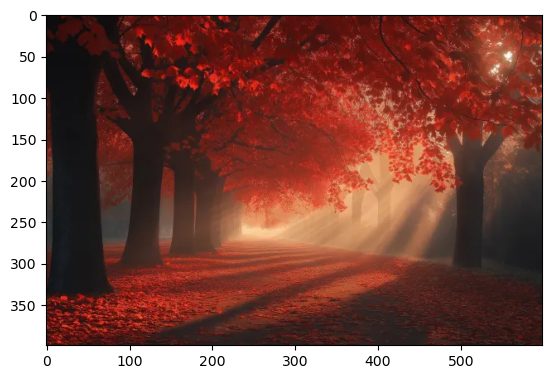

In [2]:
ls_img = mpimg.imread('landscape.jpg')
plt.imshow(ls_img)

In [3]:
print('Shape of image: ', ls_img.shape)
print('Object type of image: ', type(ls_img))                        # type() → returns what the object is (NumPy array, list, Tensor, etc.)
print('Data type of the elements inside the image: ', ls_img.dtype)  # .dtype → return what each pixel’s value type is (uint8, float32, etc.) 

Shape of image:  (399, 599, 3)
Object type of image:  <class 'numpy.ndarray'>
Data type of the elements inside the image:  uint8


**Important Note for Using Keras Pooling Layers**

1. **Input Shape Requirement:** Keras layers expect input in the format:  **`(batch_size, height, width, channels)`**  
   - Keras always expects a *batch*, even if it’s just **1 image**.  
   - Therefore, we reshape:  **`(400, 400, 3)` → `(1, 400, 400, 3)`**. This means: **1 image** of size **400×400** with **3 channels (RGB)**.


2. **Floating-Point Data Type Requirement:** Keras/TensorFlow pooling layers work only with **floating-point tensors** (`float16`, `float32`, `float64`).  
   - While Max Pooling *could* work with integers (e.g., `uint8`), TensorFlow still expects floats for consistency.  
   - Always convert image arrays to float, before sendind it to pooling layers.
   
**Note:** 
- When converting from `uint8` (0–255 range) to `float32` **without rescaling**, pixel values remain in the 0–255 range. However, `plt.imshow()` with      float images assumes values between **0.0 and 1.0**. This mismatch causes the image to appear blank — values are “too bright” and get clipped.
- `plt.imshow()` doesn’t understand batch-shaped images — it expects shape **`(height, width, channels)`** (no batch dimension). So, if your image is    shaped like **`(1, height, width, channels)`**, simply remove the batch dimension before plotting:  

```python
plt.imshow(img[0])          # Removes the first (batch) dimension
plt.imshow(np.squeeze(img)) # Squeeze removes dimensions of size 1
```

In [4]:
# Adding batch dimension
img = np.expand_dims(ls_img, axis=0)      

# Converting element type from unit8(integer) to float
img = img.astype(np.float32)

# Rescaling image
img = img/255

In [5]:
print('Shape of image: ', img.shape)
print('Object type of image: ', type(img))                        
print('Data type of the elements inside the image: ', img.dtype)

Shape of image:  (1, 399, 599, 3)
Object type of image:  <class 'numpy.ndarray'>
Data type of the elements inside the image:  float32


## Max Pooling layer

Shape of Max pooled image: (1, 199, 299, 3)


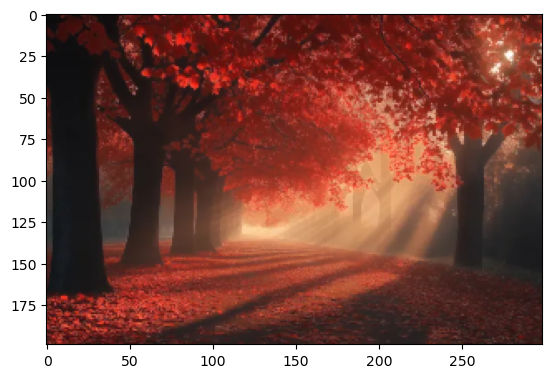

In [6]:
from tensorflow.keras.layers import MaxPooling2D

max_pool = MaxPooling2D(pool_size = (2,2), strides = 2)

max_pool_img = max_pool(img)

print('Shape of Max pooled image:', max_pool_img.shape)
plt.imshow(max_pool_img[0])                                      # Removing the batch dimension from image
plt.show()

## Average Pooling layer

Shape of Average pooled image: (1, 199, 299, 3)


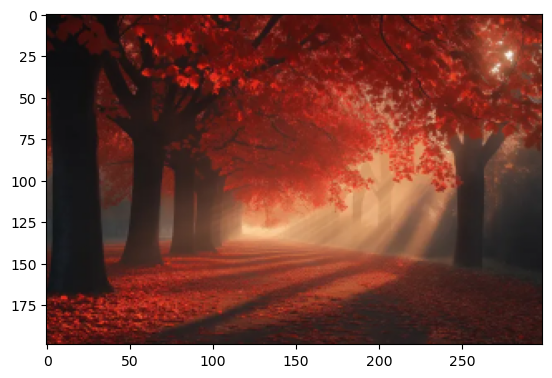

In [7]:
from tensorflow.keras.layers import AveragePooling2D

avg_pool = AveragePooling2D(pool_size = (2,2), strides = 2)

avg_pool_img = avg_pool(img)

print('Shape of Average pooled image:', avg_pool_img.shape)
plt.imshow(avg_pool_img[0])
plt.show()

## Global Pooling layer

In [8]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D

print('The shape of the image before applying pooling: ', img.shape)

# Global Max pooling
gm_pool = GlobalMaxPooling2D()
gm_img = gm_pool(img)

print('\nGlobal max pooling output: ', gm_img.numpy())
print('The shape of the Global max pooled image: ', gm_img.shape)

# Global Average pooling
ga_pool = GlobalAveragePooling2D()
ga_img = ga_pool(img)

print('\nGlobal average pooling output: ', ga_img.numpy())
print('The shape of the Global Average pooled image: ', ga_img.shape)

The shape of the image before applying pooling:  (1, 399, 599, 3)

Global max pooling output:  [[1. 1. 1.]]
The shape of the Global max pooled image:  (1, 3)

Global average pooling output:  [[0.41751567 0.19167294 0.14735019]]
The shape of the Global Average pooled image:  (1, 3)


## Custom pooling 
We will make **L2 pooling** (also called Euclidean pooling) is a type of pooling where instead of taking the max or the average of values in each pooling window, you compute the L2 norm (square root of the sum of squares) of the values in that window.
$$L2 = \sqrt{\sum_{i=1}^{n} x_i^2}$$

In [9]:
import tensorflow as tf

def l2_pool(img):
    squared_val = tf.square(img)        # Squaring all the values in numpy array img
    
    pooled_val = tf.nn.avg_pool2d(      # Doing average pooling on the 2D numpy array, with window size as 4 
        squared_val,
        ksize = (2, 2),
        strides = (2, 2),
        padding = 'VALID'
    )
    
    return tf.sqrt(pooled_val*4)       # We multiply by 4 to take the sum of squared pixel value rather than the average of the pool window.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


The shape of L2 pooled image is:  (1, 199, 299, 3)


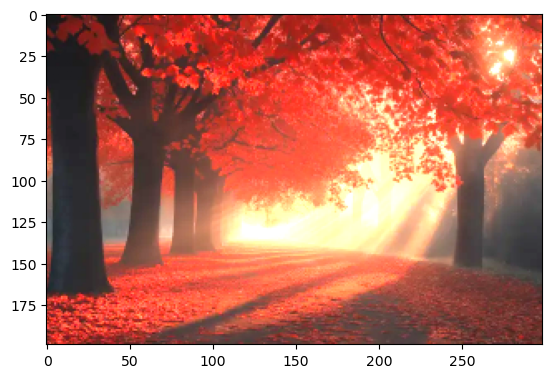

In [10]:
from tensorflow.keras.layers import Lambda

pool = Lambda(l2_pool)
l2_img = pool(img)

print('The shape of L2 pooled image is: ', l2_img.shape)
plt.imshow(l2_img[0])
plt.show()

### Why Multiply by 4 in L2 Pooling

- **L2 norm formula (window)**:  
  $$L2 = \sqrt{\sum_{i=1}^{n} x_i^2}$$

- **avg\_pool2d output** for a 2×2 window:  
  $$\text{avg} = \frac{x_1^2 + x_2^2 + x_3^2 + x_4^2}{4}$$

- To get the true L2 norm: multiply by 4 (window size), then take `sqrt`. **Final L2 pooling**:  
  $$L2 = \sqrt{\text{avg} \times 4}$$

- Without multiplying by 4 → you get:  
  $$\sqrt{\frac{\sum x_i^2}{4}} \quad \text{(RMS pooling)}$$